## Install kaggle

In [3]:
!pip install kaggle

## Working Space

I will try build image classification with tensorflow and pytorch, we will build car brands classification, dataset i get from : https://www.kaggle.com/datasets/thomasdubail/brain-tumors-256x256,
if you want to download it, get your kaggle API with this step :
1. Open kaggle
2. Click your profile then click settings
3. Scroll down until you find API, click create new token, it will donwload a file namely kaggle.json
4. upload it to your google colab / local repository.

In [9]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d thomasdubail/brain-tumors-256x256

mv: cannot stat 'kaggle.json': No such file or directory
 99% 59.0M/59.4M [00:03<00:00, 23.7MB/s]
100% 59.4M/59.4M [00:03<00:00, 16.6MB/s]


In [11]:
!unzip /content/brain-tumors-256x256.zip

Archive:  /content/brain-tumors-256x256.zip
  inflating: Data/glioma_tumor/G_1.jpg  
  inflating: Data/glioma_tumor/G_10.jpg  
  inflating: Data/glioma_tumor/G_100.jpg  
  inflating: Data/glioma_tumor/G_101.jpg  
  inflating: Data/glioma_tumor/G_102.jpg  
  inflating: Data/glioma_tumor/G_103.jpg  
  inflating: Data/glioma_tumor/G_104.jpg  
  inflating: Data/glioma_tumor/G_105.jpg  
  inflating: Data/glioma_tumor/G_106.jpg  
  inflating: Data/glioma_tumor/G_107.jpg  
  inflating: Data/glioma_tumor/G_108.jpg  
  inflating: Data/glioma_tumor/G_109.jpg  
  inflating: Data/glioma_tumor/G_11.jpg  
  inflating: Data/glioma_tumor/G_110.jpg  
  inflating: Data/glioma_tumor/G_111.jpg  
  inflating: Data/glioma_tumor/G_112.jpg  
  inflating: Data/glioma_tumor/G_113.jpg  
  inflating: Data/glioma_tumor/G_114.jpg  
  inflating: Data/glioma_tumor/G_115.jpg  
  inflating: Data/glioma_tumor/G_116.jpg  
  inflating: Data/glioma_tumor/G_117.jpg  
  inflating: Data/glioma_tumor/G_118.jpg  
  inflating: D

### Tensorflow

#### Prepare Data

In [28]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

directory = '/content/Data'

datagen = ImageDataGenerator(
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split = 0.2,
    fill_mode='nearest') # we dont rescale the image (from rgb to grayscale), but if you want to rescale, use this
                          # rescale = 1.0/255

# Flow training images in batches of 20 using train_datagen generator
train_generator = datagen.flow_from_directory(
        directory,  # This is the source directory for training images
        target_size = (256, 256),  # All images will be resized to 224x224
        batch_size = 64,
        # Since we have > 2 labels, so our class_mode will be categorical
        class_mode='categorical',
        subset='training')

# Flow validation images in batches of 20 using test_datagen generator
test_generator = datagen.flow_from_directory(
        directory,
        target_size=(256, 256),
        batch_size=64,
        class_mode='categorical',
        subset='validation')

Found 2479 images belonging to 4 classes.
Found 617 images belonging to 4 classes.


#### Build the Model

In [31]:
from tensorflow.keras import Model
import tensorflow.keras.layers as tfl

class convolution_layer(Model):
  def __init__(self, filters, kernel_size, repetitions, pool_size=2, strides=2):
    super(convolution_layer, self).__init__(name='')

    self.filters = filters
    self.kernel_size = kernel_size
    self.repetitions = repetitions

    # Define a conv2D_0, conv2D_1, etc based on the number of repetitions
    for i in range(self.repetitions):

        # Define a Conv2D layer, specifying filters, kernel_size, activation and padding.
        vars(self)[f'conv2D_{i}'] = tfl.Conv2D(self.filters, self.kernel_size, activation = 'relu', padding='same')

    # Define the max pool layer that will be added after the Conv2D blocks
    self.max_pool = tfl.MaxPool2D(pool_size, strides)

  def call(self, inputs):
        # access the class's conv2D_0 layer
        conv2D_0 = vars(self)['conv2D_0']

        # Connect the conv2D_0 layer to inputs
        x = conv2D_0(inputs)

        # for the remaining conv2D_i layers from 1 to `repetitions` they will be connected to the previous layer
        for i in range(1, self.repetitions):
            # access conv2D_i by formatting the integer `i`. (hint: check how these were saved using `vars()` earlier)
            conv2D_i = vars(self)[f'conv2D_{i}']

            # Use the conv2D_i and connect it to the previous layer
            x = conv2D_i(x)

        # Finally, add the max_pool layer
        max_pool = self.max_pool(x)

        return max_pool

class cnn_model(Model):
  def __init__(self, num_classes):
        super(cnn_model, self).__init__()

        # Creating blocks of VGG with the following
        # (filters, kernel_size, repetitions) configurations
        self.block_a = convolution_layer(16, 3, 2)
        self.block_b = convolution_layer(32, 3, 2)
        self.block_c = convolution_layer(64, 3, 2)
        self.block_d = convolution_layer(128, 3, 2)

        # Classification head
        # Define a Flatten layer
        self.flatten = tfl.Flatten()
        # Create a Dense layer with 256 units and ReLU as the activation function
        self.fc1 = tfl.Dense(256, activation = 'relu')
        self.fc2 = tfl.Dense(128, activation = 'relu')
        # Finally add the softmax classifier using a Dense layer
        self.classifier = tfl.Dense(num_classes, activation = 'softmax')

  def call(self, inputs):
        # Chain all the layers one after the other
        x = self.block_a(inputs)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = self.classifier(x)
        return x

model = cnn_model(num_classes = 4)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.8) and (logs.get('val_accuracy') > 0.75) :
            self.model.stop_training = True

# callback
callbacks = myCallback()

# Train the model
history = model.fit(train_generator, epochs=50, validation_data = test_generator, verbose = 1, validation_steps=10, callbacks = [callbacks])

Epoch 1/50
39/39 [==============================] - 49s 1s/step - loss: 1.4739 - accuracy: 0.3215 - val_loss: 1.3158 - val_accuracy: 0.3387
Epoch 2/50
39/39 [==============================] - 50s 1s/step - loss: 1.2580 - accuracy: 0.4119 - val_loss: 1.2304 - val_accuracy: 0.4263
Epoch 3/50
39/39 [==============================] - 47s 1s/step - loss: 1.1937 - accuracy: 0.4574 - val_loss: 1.1629 - val_accuracy: 0.4441
Epoch 4/50
39/39 [==============================] - 49s 1s/step - loss: 1.1497 - accuracy: 0.4760 - val_loss: 1.1308 - val_accuracy: 0.4846
Epoch 5/50
39/39 [==============================] - 47s 1s/step - loss: 1.0818 - accuracy: 0.5305 - val_loss: 1.1020 - val_accuracy: 0.4943
Epoch 6/50
39/39 [==============================] - 48s 1s/step - loss: 1.0812 - accuracy: 0.5159 - val_loss: 1.0752 - val_accuracy: 0.5122
Epoch 7/50
39/39 [==============================] - 46s 1s/step - loss: 1.0445 - accuracy: 0.5547 - val_loss: 1.0536 - val_accuracy: 0.5105
Epoch 8/50
39/39 [==

1/1 [==============================] - 1s 906ms/step


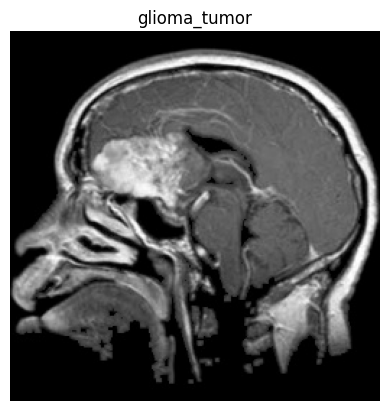

Predicted class: glioma_tumor


In [40]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Path to the image you want to test
image_path = r'/content/Data/glioma_tumor/G_1.jpg'

# Load the image and preprocess it
image = load_img(image_path, target_size=(256, 256))  # Adjust target_size according to your model's input size
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
# Assuming you need to preprocess the image further, e.g., normalizing pixel values
# image_array = preprocess_image(image_array)

# Make a prediction
predictions = model.predict(image_array)

# Assuming you have a classification model and want to get the predicted class
predicted_class = np.argmax(predictions[0])
# Assuming you have a file containing the class labels in order
class_labels = list(train_generator.class_indices.keys())
# Replace with your class labels
predicted_class_label = class_labels[predicted_class]

#show image
plt.imshow(image)
plt.title(predicted_class_label)
plt.axis('off')
plt.show()

print("Predicted class:", predicted_class_label)


In [ ]:
# save model weight

model.save_weights("model_weights.h5")

## if you want to train again, load the model weight
from tensorflow.keras.models import load_model

# Rebuild the model architecture
model = cnn_model(num_classes=4)  # Replace cnn_model with your model class

# Load the saved weights
model.load_weights("model_weights.h5")

### Pytorch

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import numpy as np

# Define data transformations
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-10, 10), fill=0),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
# Define the data directory
data_dir = '/content/Data'

# Create PyTorch dataset
full_dataset = ImageFolder(data_dir, transform=data_transforms)

# Define the split ratio
train_ratio = 0.8  # 80% for training, 20% for testing

# Split the dataset into training and testing sets
train_size = int(train_ratio * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# get the class name

# Access the class-to-index mapping
class_to_idx = train_dataset.dataset.class_to_idx

# Reverse the dictionary to get class label names
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Define the CNN model
class ConvolutionLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, repetitions, pool_size=2, strides=2):
        super(ConvolutionLayer, self).__init__()

        layers = []
        for _ in range(repetitions):
            layers.extend([
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
                nn.ReLU(inplace=True)
            ])
            in_channels = out_channels

        layers.append(nn.MaxPool2d(kernel_size=pool_size, stride=strides))
        self.conv_block = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv_block(x)

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()

        self.block_a = ConvolutionLayer(3, 16, 3, 2)
        self.block_b = ConvolutionLayer(16, 32, 3, 2)
        self.block_c = ConvolutionLayer(32, 64, 3, 2)
        self.block_d = ConvolutionLayer(64, 128, 3, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 128)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.block_a(x)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.classifier(x)
        return x

# Create the model
model = CNNModel(num_classes=4)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_test_accuracy = 0.0
best_train_accuracy = 0.0
best_model_state = None

def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = np.round(100 * correct / total, 4)
    return accuracy

# Define a training loop (you can adjust the number of epochs and other parameters)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_accuracy = calculate_accuracy(model, train_loader, device)
    test_accuracy = calculate_accuracy(model, test_loader, device)

    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss / len(train_loader)} Train Acc : {train_accuracy} Test Acc : {test_accuracy}")

    overfit = np.absolute(train_accuracy - test_accuracy)

    if (test_accuracy > best_test_accuracy) and (train_accuracy >= best_train_accuracy) and (overfit < 10.0):
      best_test_accuracy = test_accuracy
      best_train_accuracy = train_accuracy
      best_model_state = model.state_dict()

    if (best_test_accuracy > 75) and (best_train_accuracy > 80) and (overfit < 10.0):
      print("Train end in epoch :", {epoch})
      break

Epoch [1/50] Loss: 1.3642177826318986 Train Acc : 29.3619 Test Acc : 30.0
Epoch [2/50] Loss: 1.2834908755925984 Train Acc : 49.7981 Test Acc : 50.6452
Epoch [3/50] Loss: 1.0711389718911586 Train Acc : 58.441 Test Acc : 57.5806
Epoch [4/50] Loss: 1.0048135305062318 Train Acc : 60.1373 Test Acc : 59.0323
Epoch [5/50] Loss: 0.9457558034322201 Train Acc : 59.3296 Test Acc : 60.0
Epoch [6/50] Loss: 0.9399061256494278 Train Acc : 59.1276 Test Acc : 60.0
Epoch [7/50] Loss: 0.8858983379143935 Train Acc : 63.853 Test Acc : 63.871
Epoch [8/50] Loss: 0.8636760383080213 Train Acc : 68.8207 Test Acc : 67.4194
Epoch [9/50] Loss: 0.8053746349536456 Train Acc : 72.496 Test Acc : 72.5806
Epoch [10/50] Loss: 0.7527385438099886 Train Acc : 67.2859 Test Acc : 65.6452
Epoch [11/50] Loss: 0.7129269998807174 Train Acc : 73.6672 Test Acc : 72.5806
Epoch [12/50] Loss: 0.6554071116141784 Train Acc : 75.3231 Test Acc : 70.1613
Epoch [13/50] Loss: 0.6756484871491407 Train Acc : 72.3748 Test Acc : 69.3548
Epoch [1

In [43]:
# Save the model's architecture (model structure)
model_architecture_path = "model_architecture.pth"
torch.save(model, model_architecture_path)

# Save the model's state_dict (learned parameters/weights)
model_state_dict_path = "model_state_dict.pth"
torch.save(best_model_state, model_state_dict_path)

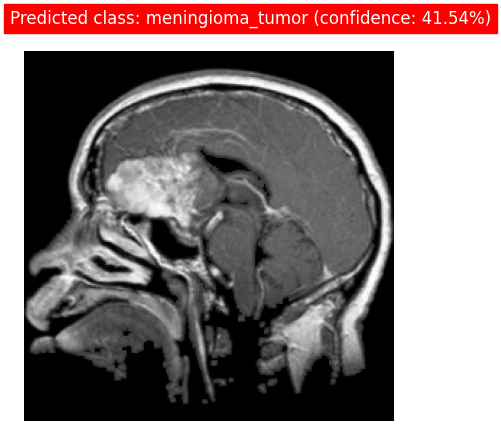

In [44]:
#Write your code for inference here

import torch
import torch.nn.functional as F
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

model.eval()

# Load an image that you want to classify (you can replace this with your image loading code)
image_path = "/content/Data/glioma_tumor/G_1.jpg"
image = Image.open(image_path).convert("RGB")

# Define transformations for the input image (should match your training transformations)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Preprocess the image
image = transform(image).unsqueeze(0)  # Add a batch dimension

# Perform inference
with torch.no_grad():
    image = image.to(device)  # Move the input image to the same device as the model
    outputs = model(image)
    probabilities = F.softmax(outputs, dim=1)  # Apply softmax to get probabilities
    predicted_class = torch.argmax(probabilities, dim=1).item()
    confidence = probabilities[0][predicted_class].item() * 100

# Create a text label
predicted_label = f"Predicted class: {idx_to_class[predicted_class]} (confidence: {confidence:.2f}%)"

# Display the image with the predicted label
image = image.cpu().squeeze().permute(1, 2, 0).numpy()
plt.imshow(image) # Convert tensor back to image format
plt.axis('off')

# Add the predicted label on top of the image
plt.text(-10, -20, predicted_label, fontsize=12, color='white', backgroundcolor='red')

plt.savefig("./submission.jpg")

plt.show()